## Selección de características

¿Por qué sería siquiera necesario seleccionar características? Para algunos, esta idea puede parecer contraintuitiva, pero existen al menos dos razones importantes para deshacerse de las características que no son relevantes.  
La primera es clara para cualquier ingeniero: **cuantos más datos, mayor complejidad computacional**. Mientras trabajemos con conjuntos de datos pequeños o de prueba (*toy datasets*), el tamaño de los datos no representa un problema; sin embargo, en sistemas de producción reales y cargados, **cientos de características adicionales pueden ser algo muy tangible**.  
La segunda razón es que **algunos algoritmos interpretan el ruido (características no informativas) como señal y terminan sobreajustando** (*overfitting*).

### Enfoques estadísticos

El candidato más obvio para eliminar es una característica cuyo valor permanece sin cambios, es decir, **no contiene información en absoluto**.  
Si partimos de esta idea, es razonable decir que **las características con baja varianza son peores que aquellas con alta varianza**. Por lo tanto, se puede considerar **eliminar las características cuya varianza esté por debajo de un cierto umbral**.


#### Basado en estadísticos no supervisado

In [1]:
# Importamos la librería NumPy para operaciones numéricas
import numpy as np

In [2]:
# Importamos la función make_classification de sklearn para generar un dataset sintético
from sklearn.datasets import make_classification

# Generamos un dataset de clasificación con parámetros por defecto
# x_data_generated: matriz de características (features)
# y_data_generated: vector de etiquetas (target)
x_data_generated, y_data_generated = make_classification(random_state=2)

# Verificamos las dimensiones del dataset generado
# Resultado: (100 muestras, 20 características)
x_data_generated.shape

(100, 20)

## VarianceThreshold

- **¿Qué es?**: Una técnica que elimina características cuya varianza no alcanza un umbral especificado.
- **Funcionamiento**: Calcula la varianza de cada característica y elimina aquellas que no superan el umbral establecido. Esto significa que las características que apenas cambian entre muestras (es decir, tienen baja varianza) se descartarán.
- **Ventajas**: Rápida y fácil de usar, útil cuando las características con baja varianza no son informativas.
- **Limitaciones**: No considera la relación con la variable objetivo, puede eliminar características útiles.


In [3]:
# Importamos VarianceThreshold para filtrar características por varianza
from sklearn.feature_selection import VarianceThreshold

# Aplicamos VarianceThreshold con umbral de 0.7
# Esto elimina características cuya varianza sea menor a 0.7
primer_filtro = VarianceThreshold(.7).fit_transform(x_data_generated)

# Verificamos cuántas características quedaron después del filtro
primer_filtro.shape

(100, 20)

In [4]:
# Probamos con un umbral más alto de 0.8
# A mayor umbral, se eliminan más características (las de menor varianza)
primer_filtro = VarianceThreshold(.8).fit_transform(x_data_generated)

# Ahora tenemos 15 características (se eliminaron 5)
primer_filtro.shape

(100, 15)

In [5]:
# Probamos con umbral de 0.9
# Umbral aún más restrictivo
primer_filtro = VarianceThreshold(.9).fit_transform(x_data_generated)

# Nos quedamos con 14 características
primer_filtro.shape

(100, 14)

In [6]:
# Probamos con umbral muy alto de 0.99
# Solo mantenemos características con muy alta varianza
primer_filtro = VarianceThreshold(.99).fit_transform(x_data_generated)

# Resultado: solo 11 características cumplen con este criterio estricto
primer_filtro.shape

(100, 11)

#### Basado en estadísticos supervisado

## SelectKBest

- **¿Qué es?**: Selecciona las K mejores características basadas en algún criterio de puntuación.
- **Funcionamiento**: Calcula un puntaje para cada característica en función de algún criterio (como la prueba F para la regresión lineal o la puntuación chi-cuadrado para la clasificación). Luego, selecciona las K características con los puntajes más altos.
- **Ventajas**: Permite seleccionar características en función de su relevancia con respecto a la variable objetivo.
- **Limitaciones**: Puede ser costoso para conjuntos de datos grandes, elección subjetiva de K.


In [7]:
# Importamos SelectKBest para selección supervisada de características
# f_classif: función de puntuación F-ANOVA para problemas de clasificación
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Aplicamos SelectKBest para seleccionar las 5 mejores características
# Este método es SUPERVISADO: considera la relación con la variable objetivo (y)
# Por defecto usa f_classif como función de scoring
x_data_kbest = SelectKBest(k=5).fit_transform(x_data_generated, y_data_generated)

In [8]:
# Verificamos que ahora tenemos solo 5 características
# Pasamos de 20 características originales a solo las 5 más relevantes
x_data_kbest.shape

(100, 5)

In [9]:
# Creamos un modelo de Regresión Logística para evaluar el rendimiento
# random_state=42 asegura reproducibilidad de resultados
logit = LogisticRegression(random_state=42)

In [10]:
# Evaluamos el modelo con TODAS las características originales (20)
# cross_val_score: validación cruzada con 5 folds
# Esto nos da una medida del rendimiento base
coss_val_res = cross_val_score(logit, x_data_generated, y_data_generated, cv=5)

# Calculamos el promedio de accuracy en los 5 folds
# Resultado: 88% de accuracy con todas las características
np.mean(coss_val_res)

np.float64(0.8800000000000001)

In [11]:
# Evaluamos el modelo con las 5 mejores características seleccionadas por SelectKBest
# Comparamos el rendimiento con el modelo que usa todas las características
coss_val_res = cross_val_score(logit, x_data_kbest, y_data_generated, cv=5)

# Resultado: 86% de accuracy
# Ligera disminución, pero usamos 75% menos características
np.mean(coss_val_res)

np.float64(0.86)

In [12]:
# Evaluamos el modelo con características filtradas por VarianceThreshold (umbral 0.9)
# Esto nos permite comparar el método NO supervisado vs el modelo base
x_data_varth = VarianceThreshold(.9).fit_transform(x_data_generated)
coss_val_res = cross_val_score(logit, x_data_varth, y_data_generated, cv=5)

# Resultado: 89% de accuracy - ¡mejor que el modelo original!
# VarianceThreshold mantuvo 14 características y obtuvo mejor rendimiento
np.mean(coss_val_res)

np.float64(0.89)

We can see that our selected features have improved the quality of the classifier. Of course, this example is purely artificial; however, it is worth using for real problems.

#### Supervisado wrapper

## RFE (Recursive Feature Elimination)

- **¿Qué es?**: Elimina recursivamente las características menos importantes hasta alcanzar el número deseado.
- **Funcionamiento**: Entrena un modelo (generalmente un modelo de aprendizaje automático) en todas las características y luego elimina las características con menor importancia. Este proceso se repite hasta que se alcanza el número deseado de características.
- **Ventajas**: Considera la interacción entre características, puede ser más robusto.
- **Limitaciones**: Puede ser costoso computacionalmente, elección del modelo y número de características.


In [13]:
# Importamos las librerías necesarias para RFE (Recursive Feature Elimination)
from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.feature_selection import RFE  # Eliminación recursiva de características
from sklearn.datasets import load_digits  # Dataset de dígitos escritos a mano
import matplotlib.pyplot as plt  # Para visualización

# Cargamos el dataset de dígitos (0-9)
# Es un conjunto de imágenes de 8x8 píxeles
digits = load_digits()

# Transformamos las imágenes 2D en vectores 1D
# reshape(-1) calcula automáticamente el tamaño
X = digits.images.reshape((len(digits.images)), -1)

# Etiquetas: los dígitos del 0 al 9
y = digits.target

In [14]:
# Verificamos las dimensiones del dataset
# 1797 muestras (imágenes)
# 64 características (8x8 = 64 píxeles por imagen)
X.shape

(1797, 64)

In [15]:
# Creamos un clasificador SVC (Support Vector Classifier) con kernel lineal
svc = SVC(kernel="linear", C=1)

# Configuramos RFE para seleccionar las 10 características más importantes
# RFE funciona de manera RECURSIVA:
# 1. Entrena el modelo con todas las características
# 2. Elimina la característica menos importante (step=1)
# 3. Repite hasta tener solo 10 características
rfe = RFE(estimator=svc, n_features_to_select=10, step=1)

# Ajustamos el modelo RFE con nuestros datos
rfe.fit(X, y)

,estimator,"SVC(C=1, kernel='linear')"
,n_features_to_select,10
,step,1
,verbose,0
,importance_getter,'auto'
,C,1
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True


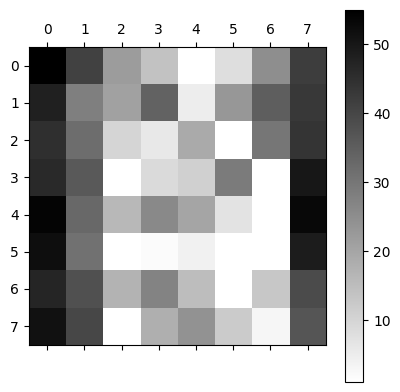

In [19]:
# rfe.ranking_ nos da el ranking de importancia de cada característica
# 1 = las más importantes (seleccionadas)
# Números mayores = menos importantes (eliminadas primero)

# Reformateamos el ranking para tener la forma original de la imagen (8x8)
ranking = rfe.ranking_.reshape(digits.images[0].shape)

# Visualizamos el ranking de características en forma de mapa de calor
# Los píxeles más oscuros (ranking=1) son los más importantes para clasificar dígitos
# Los píxeles claros fueron eliminados antes (menos importantes)
plt.matshow(ranking, cmap='binary')
plt.colorbar();